<a href="https://colab.research.google.com/github/iannwtf19/iannwtf19/blob/main/Week3/Tensorflow_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

First we load our MNIST data as two separate datasets for training and testing

In [52]:
(train_ds, test_ds), ds_info = tfds.load ("mnist", split =[ "train", "test" ], as_supervised = True, with_info = True )

Let's have a look at our dataset information

In [53]:
print(ds_info)
md(f"* **Number of training images:** {ds_info.splits['train'].num_examples}\n"
   f"* **Number of test images:** {ds_info.splits['test'].num_examples}\n"
   f"* **Image shape:** {ds_info.features['image'].shape}\n"
   f"* **Range of pixel values:** 0-255")

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


* **Number of training images:** 60000
* **Number of test images:** 10000
* **Image shape:** (28, 28, 1)
* **Range of pixel values:** 0-255

* **Number of training images:** 60000
* **Number of test images:** 10000
* **Image shape:** 28x28
* **Range of pixel values:** 0-255

Our data looks like this:

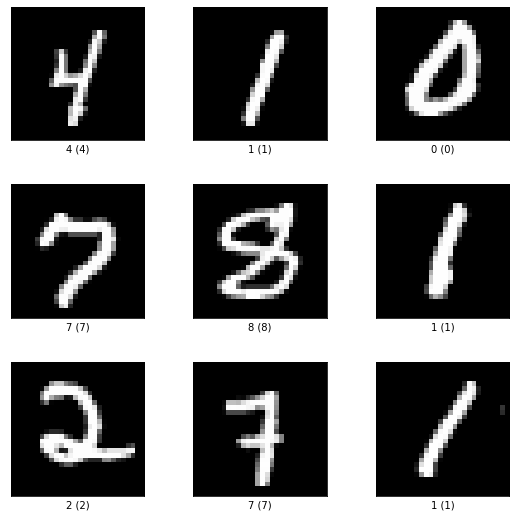

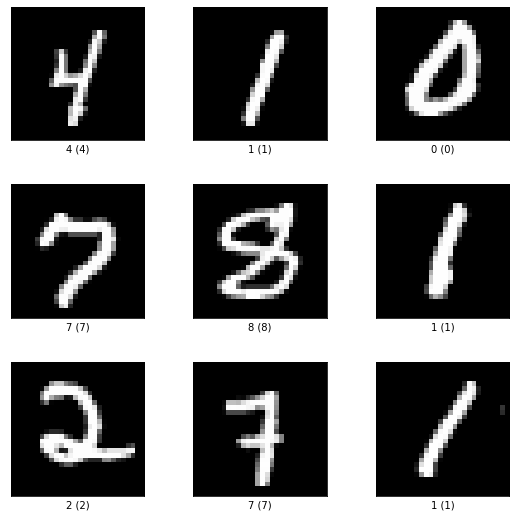

In [30]:
tfds.show_examples(train_ds, ds_info)

Function for preprocessing the dataset

In [54]:
def mnist_prepare(mnist):
    """
    Pre-process mnist dataset
    :param mnist: mnist dataset
    :return: dataset with float values, input as tensor between -1 and 1, target as one-hot tensor
    """
    # change the datatype from uint8 to tf.float values (first lambda task)
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # flatten the images (second lambda task)
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))

    # normalize the values (third lambda task)
    mnist = mnist.map(lambda img, target: ((img / 128.) - 1, target))

    # one-hot vector (fourth lambda task)
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    mnist.cache()

    return mnist

Let's use it to prepare the training and test datasets

In [55]:
# Prepare train dataset
train_ds = mnist_prepare(train_ds)
train_ds = train_ds.shuffle(ds_info.splits['train'].num_examples)
train_ds = train_ds.batch(32)
train_ds = train_ds.prefetch(32)

# Prepare test dataset
test_ds = mnist_prepare(test_ds)
test_ds = test_ds.shuffle(ds_info.splits['test'].num_examples)
test_ds = test_ds.batch(32)
test_ds = test_ds.prefetch(32)

We define our hyperparameters

In [56]:
# Hyperparameters
no_epochs = 10
learning_rate = 0.01

# Loss function will be Categorical Cross Entropy since this is a classification task
loss_func = tf.keras.losses.CategoricalCrossentropy()

# Use gradient descent optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

Let's define our model

In [57]:
class Model(tf.Module):

    def __init__(self):
        super(Model, self).__init__()

        self.dense1 = tf.keras.layers.Dense(units=64, activation="relu")
        self.dense2 = tf.keras.layers.Dense(units=64, activation="relu")
        self.out = tf.keras.layers.Dense(units=10, activation="softmax")

    @tf.function
    def __call__(self, input):
        x = self.dense1(input)
        x = self.dense2(x)
        x = self.out(x)

        return x

Let's define our training function

In [58]:
def training(model, train_ds, loss_func, optimizer):
    """
    :param model: Tensorflow model to be used
    :param train_ds: Training dataset that will be used to train the model
    :param loss_func: Keras loss function
    :param optimizer: Keras optimizer
    :return: Average loss for the given training dataset
    """
    losses = []
    for input, target in train_ds:
        with tf.GradientTape() as tape:
            prediction = model(input)
            loss = loss_func(target, prediction)
        losses.append(loss)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return tf.reduce_mean(losses)

And define our test function

In [59]:
def test(model, test_ds, loss_func):
    """
    :param model: Tensorflow model to be used
    :param test_ds: Test dataset
    :param loss_func: Keras loss function
    :return: Average loss for the given test dataset
    """
    losses = []
    accuracies = []

    for input, target in test_ds:
        prediction = model(input)
        loss = loss_func(target, prediction)
        acc = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)  # Prediction correct or not?
        losses.append(loss.numpy())
        accuracies.append(np.mean(acc))  # Percentage of correct predictions

    test_loss = tf.reduce_mean(losses)
    test_acc = tf.reduce_mean(accuracies)

    return test_loss, test_acc

**Initialization**
Here we initialize our model, losses and accuracies.
Then we test our model with test and training datasets once, to see how it performs without training.

In [60]:
model = Model()
# Losses and accuracies that will be plotted later
training_losses = []
test_losses = []
test_accuracies = []

# Calculate initial losses and accuracies before any training
training_loss, _ = test(model, train_ds, loss_func)
print(f"Initial training loss: {training_loss}")
training_losses.append(training_loss)
test_loss, test_acc = test(model, test_ds, loss_func)
print(f"Initial test loss: {test_loss}")
print(f"Initial test accuracy: {test_acc}")
test_losses.append(test_loss)
test_accuracies.append(test_acc)

Initial training loss: 2.784440040588379
Initial test loss: 2.7595911026000977
Initial test accuracy: 0.10343450479233227


**Training Loop**

In [61]:
for i in range(no_epochs):
    loss = training(model, train_ds, loss_func, optimizer)
    print(f"- Epoch {i} -")
    print(f"Mean training loss: {loss}")
    training_losses.append(loss)

    test_loss, test_acc = test(model, test_ds, loss_func)
    print(f"Mean test loss: {test_loss}")
    print(f"Mean test accuracy: {test_acc}")
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

- Epoch 0 -
Mean training loss: 0.47328951954841614
Mean test loss: 0.2790221571922302
Mean test accuracy: 0.919129392971246
- Epoch 1 -
Mean training loss: 0.2649197578430176
Mean test loss: 0.23058784008026123
Mean test accuracy: 0.9300119808306709
- Epoch 2 -
Mean training loss: 0.2161666452884674
Mean test loss: 0.20399489998817444
Mean test accuracy: 0.9359025559105432
- Epoch 3 -
Mean training loss: 0.18517036736011505
Mean test loss: 0.17793986201286316
Mean test accuracy: 0.9479832268370607
- Epoch 4 -
Mean training loss: 0.16360948979854584
Mean test loss: 0.18158075213432312
Mean test accuracy: 0.9450878594249201
- Epoch 5 -
Mean training loss: 0.1469196379184723
Mean test loss: 0.14873093366622925
Mean test accuracy: 0.9571685303514377
- Epoch 6 -
Mean training loss: 0.13337743282318115
Mean test loss: 0.14483264088630676
Mean test accuracy: 0.9564696485623003
- Epoch 7 -
Mean training loss: 0.1225220113992691
Mean test loss: 0.12997812032699585
Mean test accuracy: 0.9607627

**Visualization**

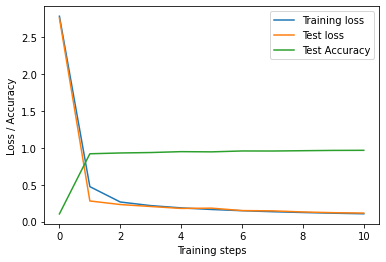

In [62]:
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss / Accuracy")
plt.legend((line1, line2, line3), ("Training loss", "Test loss", "Test Accuracy"))
plt.show()